### Observations about circular couplings

1. Waiting for things to exactly meet is completely infeasible in some situations --- for example, the Glynn and Rhee example where $X_{n+1} = 1/2 X_n + \text{Bern}(0.5)$, since the support of $X_{n+1}$ is completely determined by $X_n$. But they still get very close to each other.

- Could make the state space discrete
- Could use smoothness of the $f$-function to argue that if they don't exactly meet, it's A-okay [contractive markov chains and lischpitz functions]

- Use randomly chosen $N$ in circular couplings too

- Start with how far off you want to be --- estimating a lischpitz function --- then this automatically determines a new discrete state space

   - Need smoothness on $f$ and transition matrix: need to think carefully about how to construct the new transition matrix

- Ising model

### Problem set-up

Suppose we have a kernel $K$ and a stationary distribution $\pi$. We are interested in estimating

$$\mathbb{E}_{X \sim \pi}[f(X)].$$

Two ways to formulate it:
1. Find $\pi^*$ such that $\mathbb{E}_{X \sim \pi}[f(X)] \approx \mathbb{E}_{X \sim \pi'}[f(X)]$, but it's easy to sample from $pi'$. I don't like this formulation very much.


2. Suppoes that there is a distance metric $d$ on the state space $\Omega$ such that $f$ is continuous/Lischpitz/something with respect to $d$. 

As a really simple example, suppose $|f(x) - f(y)| < \epsilon$ if $|x - y| < \delta$. We will generate data $X^*$ such that there is a coupling where $|X - X^*| < \delta$ and $X \sim \pi$. This implies $|f(X) - f(X^*)| < \epsilon$.

### True DGP

In [1]:
### This code just generates pi and K.
import numpy as np
import scipy 
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1234)
d = 5

## Generate random stochastic matrix
K = np.eye(d)
K = np.random.uniform(size=(d, d))
K = K / K.sum(axis=1, keepdims=True)

## Find invariant distribution pi (using convex solver)
import cvxpy as cp
pi = cp.Variable(d)
constraints = [
    cp.sum(pi) == 1,
    pi <= 1,
    pi >= 0,
    pi @ K == pi
]
problem = cp.Problem(objective=cp.Maximize(1), constraints=constraints)
problem.solve()
pi = pi.value

## Check invariant dist is correct
assert np.abs(pi - np.dot(pi, K)).mean() < 1e-5
print("pi =", pi)
print("pi K =", np.dot(pi, K))
print("K does seem to be pi-invariant!")

pi = [0.13953703 0.19482107 0.11068456 0.24536522 0.30959211]
pi K = [0.13953703 0.19482107 0.11068456 0.24536522 0.30959211]
K does seem to be pi-invariant!


In [2]:
K

array([[0.0679945 , 0.22086516, 0.15540499, 0.27882319, 0.27691216],
       [0.08558635, 0.08680194, 0.25176512, 0.30082859, 0.27501801],
       [0.1362995 , 0.1908387 , 0.26034421, 0.27148194, 0.14103565],
       [0.20530199, 0.18404254, 0.0050369 , 0.28272259, 0.32289598],
       [0.15476829, 0.2610235 , 0.03197335, 0.15643862, 0.39579624]])

In [3]:
def sample_discrete_rvs(pi0, reps, seed):
    """
    pi0 must be of shape (d, reps) or (d,) 
    
    The seed determines the uniforms
    """
    
    # Cumsum
    cumpi0 = np.cumsum(pi0, axis=0)
    
    # Sample uniforms and output
    np.random.seed(seed)
    unifs = np.random.uniform(size=(1, reps))
    
    # If 1-dimensional pi0, reshape to make 2d
    if (len(cumpi0.shape) == 1):
        cumpi0 = cumpi0.reshape(-1, 1)
        
    flags = unifs <= cumpi0 # d x reps
    return np.argmax(flags, axis=0)

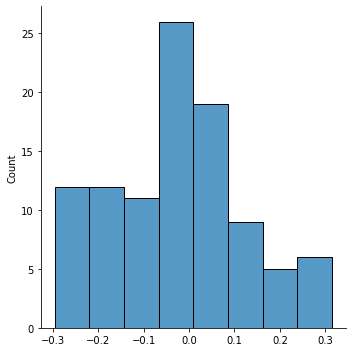

In [5]:
class CircularCoupler():
    """
    K : np.ndarray
        Transition matrix
    N : int
        Number of samples
    reps : int
        Number of replications
    """
    
    def __init__(
        self, 
        K, 
        N, 
        reps
    ):
        self.K = K
        self.N = N
        self.reps = reps
        self.d = self.K.shape[0]
        
    def forward(self, pi0=None):
        """
        pi0 : np.ndarray
            initial distribution, sums to 1
        """
        if pi0 is None:
            pi0 = np.ones((self.d,))/self.d
        
        # reps-dimensional vector
        x0s = sample_discrete_rvs(pi0, self.reps, seed=0)
        
        # transitions
        self.xs = [x0s]
        for j in range(self.N - 1):
            self.xs.append(
                sample_discrete_rvs(K[self.xs[-1]].T, self.reps, seed=j)
            )
        
        # Make a numpy array
        self.xs = np.array(self.xs)
        return self.xs
    
    def backward(self):
        
        y0s = self.xs[-1]
        self.ys = [y0s]
        for j in range(self.N - 1):
            self.ys.append(
                sample_discrete_rvs(K[self.ys[-1]].T, self.reps, seed=j)
            )
        
        self.ys = np.array(self.ys)
        return self.ys
    
    def compute_estimates(self, pi, func=None):
        """
        pi is the stationary distribution
        """
        if func is None:
            func = lambda x: x
        func = np.vectorize(func)
        
        theta = np.sum(func(np.arange(d)) * pi)
        converged = self.ys[-1] == self.xs[-1]
        hatthetas = func(self.ys[:, converged]).mean(axis=0)
        return hatthetas, theta
        
        

### Actually run this
sampler = CircularCoupler(K=K, N=105, reps=100)
x = sampler.forward()
y = sampler.backward()
hatthetas, theta = sampler.compute_estimates(pi, func=None)
sns.displot(hatthetas - theta)
plt.show()

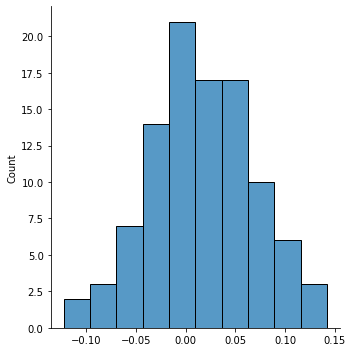

In [17]:
class ContractionCircularCoupler():
    """
    K : np.ndarray
        Transition matrix
    N : int
        Number of samples
    reps : int
        Number of replications
    """
    
    def __init__(
        self, 
        N, 
        reps
    ):
        self.N = N
        self.reps = reps
        
    def forward(self, x0s=None):
        """
        pi0 : np.ndarray
            initial distribution, sums to 1
        """
        if x0s is None:
            np.random.seed(0)
            x0s = np.random.uniform(high=2.0, size=(self.reps,))
        
        # transitions
        self.xs = [x0s]
        for j in range(self.N - 1):
            np.random.seed(j)
            self.xs.append(
                (self.xs[-1] + np.random.binomial(1, 0.5, size=(self.reps))) / 2.0
            )
        
        # Make a numpy array
        self.xs = np.array(self.xs)
        return self.xs
    
    def backward(self):
        
        y0s = self.xs[-1]
        self.ys = [y0s]
        for j in range(self.N - 1):
            np.random.seed(j)
            self.ys.append(
                (self.ys[-1] + np.random.binomial(1, 0.5, size=(self.reps))) / 2.0
            )
        
        self.ys = np.array(self.ys)
        return self.ys
    
    def compute_estimates(self, func=None):
        """
        pi is the stationary distribution
        """
        if func is None:
            func = lambda x: x
        func = np.vectorize(func)
        
        theta = np.sum(func(np.arange(0, 1, 0.05)) * 0.05)
        converged = self.ys[-1] == self.xs[-1]
        hatthetas = func(self.ys[:, converged]).mean(axis=0)
        return hatthetas, theta
        
        

### Actually run this
sampler = ContractionCircularCoupler(N=105, reps=100)
x = sampler.forward()
y = sampler.backward()
hatthetas, theta = sampler.compute_estimates(func=None)
sns.displot(hatthetas - theta)
plt.show()

In [16]:
print(x[-5:,2])
print( y[-5:,2])
print(x[:5,2])
print(y[:5,2])

[0.61073202 0.30536601 0.152683   0.0763415  0.03817075]
[0.61073202 0.30536601 0.152683   0.0763415  0.03817075]
[1.20552675 1.10276338 0.55138169 0.77569084 0.38784542]
[0.03817075 0.51908538 0.25954269 0.62977134 0.31488567]
